In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
from src import TimeSeriesLSTM

In [3]:
# load excel files from ../data/raw/WDSA into a pandas dataframe, col 0 Date-time CET-CEST (DD/MM/YYYY HH:mm)
df_inflow = pd.read_excel('data/raw/WDSA/InflowData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')
df_weather = pd.read_excel('data/raw/WDSA/WeatherData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')

In [4]:
# linearly interpolate all the missing values
df_inflow = df_inflow.interpolate(method='linear').dropna()
df_weather = df_weather.interpolate(method='linear').dropna()

# get latest start date of both datasets
start_date = max(df_inflow.index.min(), df_weather.index.min())

# get earliest end date of both datasets
end_date = min(df_inflow.index.max(), df_weather.index.max())

# get the intersection of both datasets
df_inflow = df_inflow.loc[start_date:end_date]
df_weather = df_weather.loc[start_date:end_date]

# normalize weather with min max and inflow with z-normalization, save mean of inflow for later
df_inflow_mean = df_inflow.mean()
df_inflow_std = df_inflow.std()
df_inflow = (df_inflow - df_inflow_mean) / df_inflow_std
df_weather = (df_weather - df_weather.min()) / (df_weather.max() - df_weather.min())

# divide into first 75% training and 25% validation
divider = int(len(df_inflow) * 0.75)
df_inflow_train = df_inflow.iloc[:divider]
df_inflow_val = df_inflow.iloc[divider:]
df_weather_train = df_weather.iloc[:divider]
df_weather_val = df_weather.iloc[divider:]

# merge datasets
df_train = pd.merge(df_inflow_train, df_weather_train, left_index=True, right_index=True)
df_val = pd.merge(df_inflow_val, df_weather_val, left_index=True, right_index=True)

In [5]:
df_train.columns

Index(['DMA A (L/s)', 'DMA B (L/s)', 'DMA C (L/s)', 'DMA D (L/s)',
       'DMA E (L/s)', 'DMA F (L/s)', 'DMA G (L/s)', 'DMA H (L/s)',
       'DMA I (L/s)', 'DMA J (L/s)', 'Rainfall depth (mm)',
       'Air temperature (°C)', 'Air humidity (%)', 'Windspeed (km/h)'],
      dtype='object')

In [21]:
# create a TimeSeriesLSTM object
model = TimeSeriesLSTM(
    df_train=df_train,
    df_val=df_val,
    target_feature='DMA A (L/s)',
    historic_features=['DMA A (L/s)'],
    future_features=['Air temperature (°C)', 'Air humidity (%)'],
    historic_sequence_length=24,
    prediction_horizon_length=24,
    batch_size=32,
    epochs=100,
    learning_rate=0.001,
    loss_function=nn.MSELoss(),
    lstm_hidden_size=1,
    lstm_layers=5,
    lstm_dropout=0.1,
    decoder_size=[24, 5], # [24 ,5] means 5 layers with 24 neurons each
    decoder_dropout=0.1,
    activation_function_decoder=nn.ReLU()
)

In [22]:
model.train()

Untrained val
--------
val loss: 1.0844974536256693

Epoch 1
-----
Train loss: 0.8377070230286138
val loss: 0.8003161718550417
Epoch 2
-----
Train loss: 0.7389671857259712
val loss: 0.7230534559672641
Epoch 3
-----
Train loss: 0.69444450269751
val loss: 0.6941901368578685
Epoch 4
-----
Train loss: 0.6813930179797062
val loss: 0.6837089961951541
Epoch 5
-----
Train loss: 0.6750680461627285
val loss: 0.6843691787768885
Epoch 6
-----
Train loss: 0.6706474576474858
val loss: 0.6731667352705887
Epoch 7
-----
Train loss: 0.6683876692843275
val loss: 0.6720184714523787
Epoch 8
-----
Train loss: 0.6586068177304301
val loss: 0.6351750594438966
Epoch 9
-----
Train loss: 0.6366817181815907
val loss: 0.6085628065251812
Epoch 10
-----
Train loss: 0.6251786856018767
val loss: 0.6109010869080258
Epoch 11
-----
Train loss: 0.6142490155437366
val loss: 0.5975554250564772
Epoch 12
-----
Train loss: 0.6104139163583314
val loss: 0.5935672527735996
Epoch 13
-----
Train loss: 0.6045632735401595
val loss: 0.

In [35]:
# predict 24 hours into the future
df_prediction_data = df_val.iloc[2000:2100]
model.set_prediction_data(df_prediction_data)
df_prediction = model.predict(0)

# transform df_prediction back to original scale
df_prediction['DMA A (L/s)_pred'] = df_prediction['DMA A (L/s)_pred'] * df_inflow_std['DMA A (L/s)'] + df_inflow_mean['DMA A (L/s)']
df_truth = df_prediction_data[['DMA A (L/s)']] * df_inflow_std['DMA A (L/s)'] + df_inflow_mean['DMA A (L/s)']
df_truth = df_truth.iloc[:48]

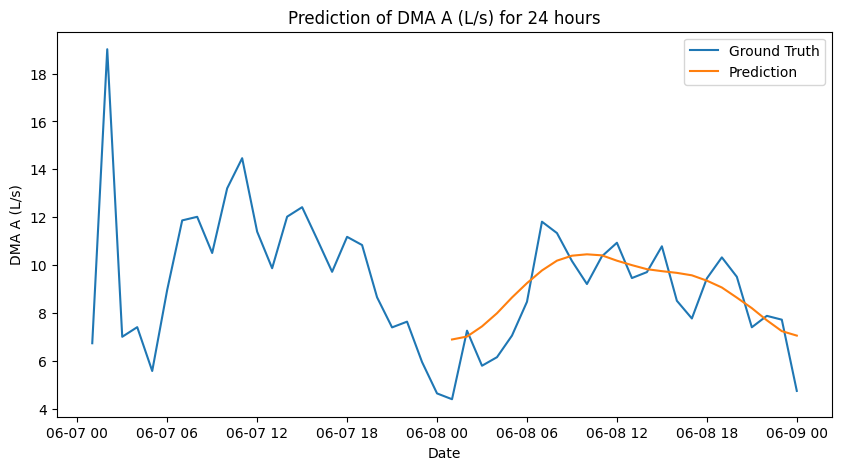

In [38]:
# plot prediction along with prediction data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_truth.index, df_truth['DMA A (L/s)'], label='Ground Truth')
ax.plot(df_prediction.index, df_prediction['DMA A (L/s)_pred'], label='Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('DMA A (L/s)')
ax.legend()
ax.set_title('Prediction of DMA A (L/s) for 24 hours')
plt.show()

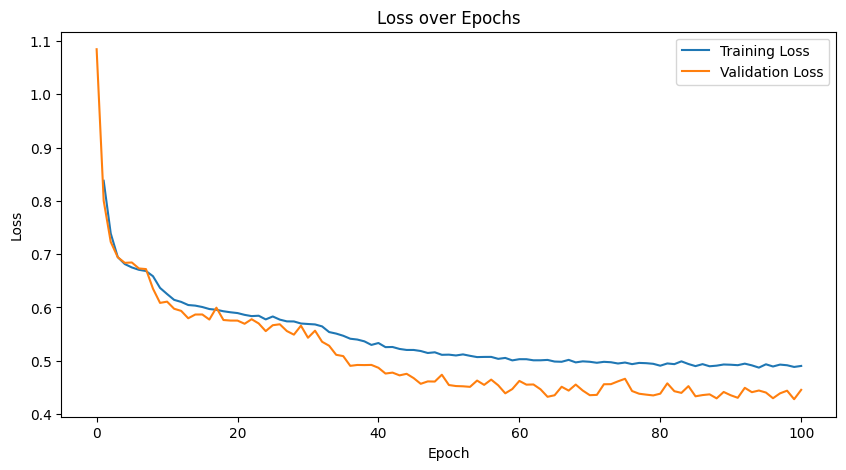

In [39]:
# plot loss over epochs
# note that the first validation loss is an untrained loss and thus trained before the first epoch
# the first training loss is the loss after the first epoch
model.train_losses
model.val_losses

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, len(model.train_losses)+1), model.train_losses, label='Training Loss')
ax.plot(np.arange(0, len(model.val_losses)),model.val_losses, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Loss over Epochs')
plt.show()

